In [43]:
import torch

# Check if CUDA (GPU) is available
if torch.cuda.is_available():
    print("CUDA is available. PyTorch can use the GPU.")
    print("Number of available GPUs:", torch.cuda.device_count())
    print("Current GPU device:", torch.cuda.current_device())
    print("GPU Name:", torch.cuda.get_device_name(torch.cuda.current_device()))
else:
    print("CUDA is not available. PyTorch will use the CPU.")

CUDA is available. PyTorch can use the GPU.
Number of available GPUs: 1
Current GPU device: 0
GPU Name: NVIDIA GeForce RTX 3050 Laptop GPU


In [21]:
import torch

# Before starting the training loop
torch.cuda.empty_cache()

In [22]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.transforms import transforms
import torch.optim as optim
import os
import cv2
from glob import glob
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, confusion_matrix

In [23]:
dataset_path = "C:/Users/91623/Desktop/Brain_tumor_research/Data"
train_path = "C:/Users/91623/Desktop/Brain_tumor_research/Data/Training"
test_path = "C:/Users/91623/Desktop/Brain_tumor_research/Data/Testing"
image_size = (256,256)
num_classes = 4
train_paths = glob(f"{train_path}/*/*.jpg")
test_paths = glob(f"{test_path}/*/*.jpg")

In [24]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10),
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [25]:
class dataset(Dataset):
    def __init__(self,paths,transform=None):
        self.paths = paths
        self.transform = transform
        self.labels = [self.get_label(path) for path in self.paths]
        self.labels_to_index = {label:index for index,label in enumerate(list(set(self.labels)))}
    
    def __getitem__(self,index):
        img_path = self.paths[index]
        img = Image.open(img_path).convert('RGB') 
        label = self.labels[index]
        label_index = self.labels_to_index[label]
        
        if self.transform:
            img = self.transform(img)
        
        return img, label_index,label
    
    
    def __len__(self):
        return len(self.paths)
    
    
    def get_label(self, path):
        return os.path.basename(os.path.dirname(path))


In [26]:
train_dataset = dataset(train_paths, transform=train_transform)
test_dataset = dataset(test_paths, transform=test_transform)

In [27]:
val_dataset, test_dataset = train_test_split(test_dataset,test_size=0.5, random_state=ord("H"))

In [28]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [29]:
import torch
import torch.nn as nn
from torchvision import models

class CustomModel(nn.Module):
    def __init__(self, num_classes=4):
        super(CustomModel, self).__init__()
        self.resnet = models.resnet50(weights='ResNet50_Weights.IMAGENET1K_V1')
        self.resnet = nn.Sequential(*list(self.resnet.children())[:-2])
        
        self.conv1 = nn.Conv2d(2048, 128, kernel_size=4, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(128)
        
        self.conv2 = nn.Conv2d(128, 128, kernel_size=4, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 3 * 3, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.resnet(x)
        x = self.conv1(x)
        x = self.bn1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = torch.relu(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [30]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CustomModel(num_classes=4).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [31]:
def train_epoch():
    model.train()
    total_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    
    for batch_number, (images, labels_indices, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels_indices.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()
        
    avg_loss = total_loss / len(train_loader)
    accuracy = correct_predictions / total_predictions
    return avg_loss, accuracy

In [32]:
def eval_model():
    model.eval()
    total_loss = 0.0 
    total_correct = 0
    total_predictions = 0
    
    with torch.no_grad():
        for batch_number, (images, labels_indices, labels) in enumerate(val_loader):
            images, labels_indices = images.to(device), labels_indices.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels_indices)
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_predictions += labels_indices.size(0)
            total_correct += (predicted == labels_indices).sum().item()
            
    avg_loss = total_loss / len(val_loader)
    avg_accuracy = total_correct / total_predictions
    
    return avg_loss, avg_accuracy

In [33]:
train_losses = []
val_losses = []
5
train_accuracies = []
val_accuracies = []
best_score = float("inf")
n_epochs = 40
tolerance = 0

for epoch in range(n_epochs):
    print(f"Epoch {epoch},   ", end="")
    avg_train_loss, train_accuracy = train_epoch()
    avg_eval_loss, eval_accuracy = eval_model()
    
    if avg_eval_loss < best_score:
        best_score = avg_eval_loss
        torch.save(model.state_dict(), f"model_{epoch+1}")
        tolerance = 0
    else:
        tolerance += 1
        if tolerance >= 8:
            break
            
    train_losses.append(avg_train_loss)
    val_losses.append(avg_eval_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(eval_accuracy)
    
    print(f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy * 100:.2f}%")
    print(f"Eval Loss: {avg_eval_loss:.4f}, Eval Accuracy: {eval_accuracy * 100:.2f}%")

Epoch 0,   Train Loss: 0.7953, Train Accuracy: 70.12%
Eval Loss: 0.7308, Eval Accuracy: 70.69%
Epoch 1,   Train Loss: 0.5571, Train Accuracy: 79.45%
Eval Loss: 0.5653, Eval Accuracy: 75.57%
Epoch 2,   Train Loss: 0.4297, Train Accuracy: 84.84%
Eval Loss: 1.2891, Eval Accuracy: 62.14%
Epoch 3,   Train Loss: 0.3959, Train Accuracy: 85.64%
Eval Loss: 2.4310, Eval Accuracy: 42.60%
Epoch 4,   Train Loss: 0.3330, Train Accuracy: 87.90%
Eval Loss: 0.3700, Eval Accuracy: 85.04%
Epoch 5,   Train Loss: 0.3133, Train Accuracy: 88.76%
Eval Loss: 0.6054, Eval Accuracy: 80.92%
Epoch 6,   Train Loss: 0.2911, Train Accuracy: 89.32%
Eval Loss: 0.4085, Eval Accuracy: 86.72%
Epoch 7,   Train Loss: 0.2436, Train Accuracy: 91.49%
Eval Loss: 0.3038, Eval Accuracy: 89.16%
Epoch 8,   Train Loss: 0.2340, Train Accuracy: 91.88%
Eval Loss: 0.5660, Eval Accuracy: 81.68%
Epoch 9,   Train Loss: 0.2185, Train Accuracy: 91.96%
Eval Loss: 0.2117, Eval Accuracy: 91.45%
Epoch 10,   Train Loss: 0.2094, Train Accuracy: 92

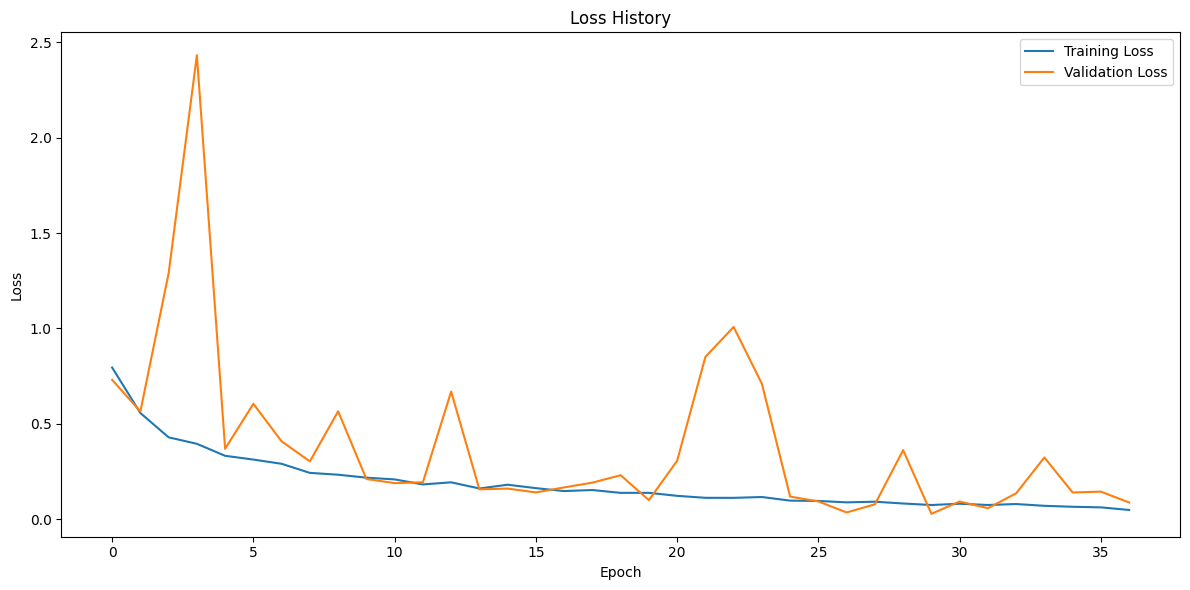

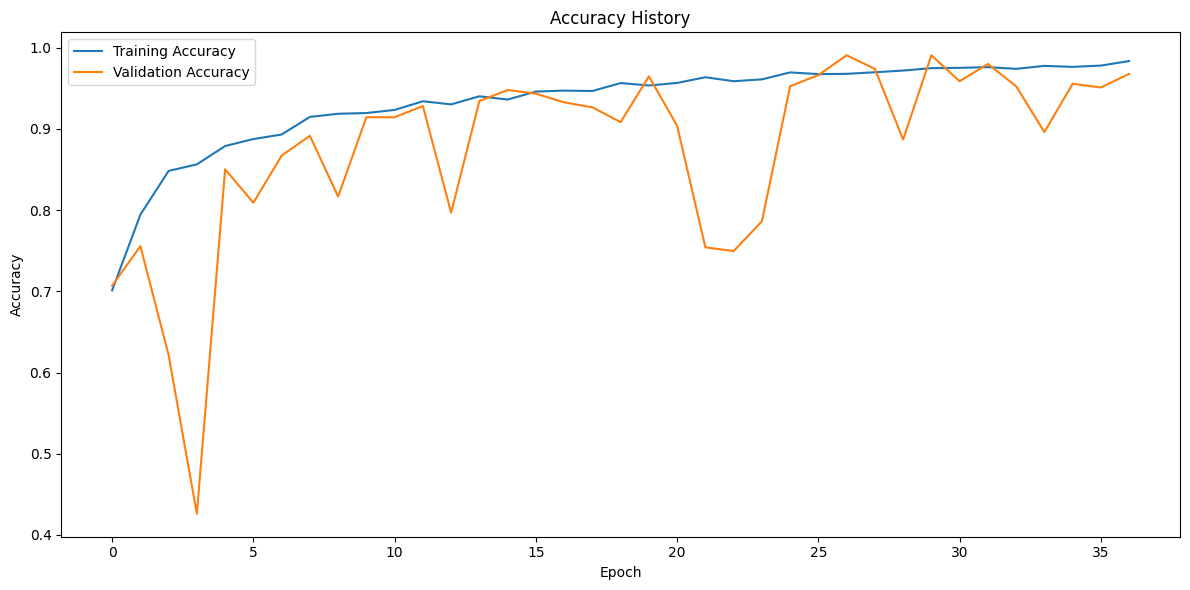

In [44]:
import matplotlib.pyplot as plt

# Plotting loss history
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss History')
plt.tight_layout()
plt.show()

# Plotting accuracy history
plt.figure(figsize=(12, 6))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy History')
plt.tight_layout()
plt.show()


In [45]:
models = glob("C:/Users/91623/Desktop/Brain_tumor_research/new_code/*")
model_num = [int(i.split("_")[-1]) for i in models if i.split("_")[-1].isdigit()]
best_model_path = "C:/Users/91623/Desktop/Brain_tumor_research/new_code/model_" +str(sorted(model_num)[-1])
best_model_path

'C:/Users/91623/Desktop/Brain_tumor_research/new_code/model_30'

In [46]:
from torchvision import models
resnet = models.resnet50(pretrained=True)
best_model = CustomModel(num_classes=4).to(device)

# Load the state dictionary from the best model path
pretrained_dict = torch.load(best_model_path, map_location=device)

# Filter out unnecessary keys
model_dict = best_model.state_dict()
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}

# Update the state dictionary
model_dict.update(pretrained_dict)

# Load the updated state dictionary into the model
best_model.load_state_dict(model_dict)

# Optional: Verify the model
print(best_model)


c:\Users\91623\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\91623\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


CustomModel(
  (resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(6

In [47]:
def predict(
    model:nn.Module, 
    sample_loader:torch.utils.data.DataLoader,
    device:torch.device) -> np.ndarray:
    model.eval()
    predictions = []
    with torch.inference_mode():
        for batch, (X, y,labels) in enumerate(sample_loader):
            X, y = X.to(device), y.to(device)
            y_pred = model(X) 
            predictions.append(y_pred.cpu().numpy())
        
    return np.vstack(predictions)

In [48]:

best_model_props = predict(best_model, test_loader, device)
best_model_preds = np.argmax(best_model_props, axis=1)
best_model_preds.shape[0]

656

In [49]:
gen_labels_test_set = [label[1] for label in test_dataset]
len(gen_labels_test_set)


656

In [50]:
print(f"Best Model Test Accuracy: {round(accuracy_score(gen_labels_test_set,best_model_preds)*100,2)}%")

Best Model Test Accuracy: 97.87%


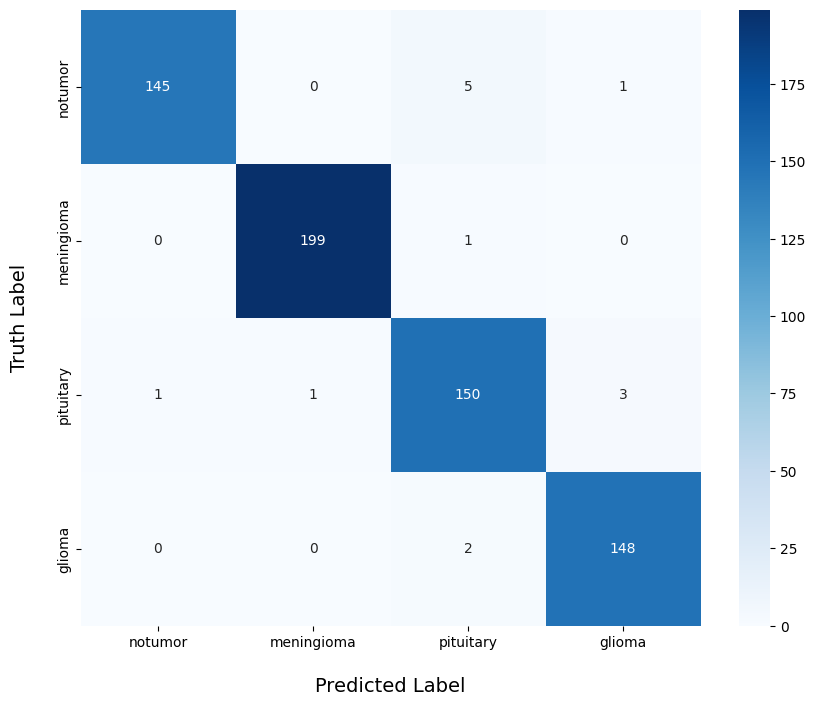

Precision: 0.9789181154539361
Recall: 0.9786585365853658
F1 Score: 0.9786939715095049


In [51]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
cm = confusion_matrix(gen_labels_test_set, best_model_preds)
precision = precision_score(gen_labels_test_set, best_model_preds, average='weighted')
recall = recall_score(gen_labels_test_set, best_model_preds, average='weighted')
f1 = f1_score(gen_labels_test_set, best_model_preds, average='weighted')
labels = set([label[2] for label in test_dataset])
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label', labelpad=20, fontsize=14)
plt.ylabel('Truth Label', labelpad=20, fontsize=14)
plt.show()
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

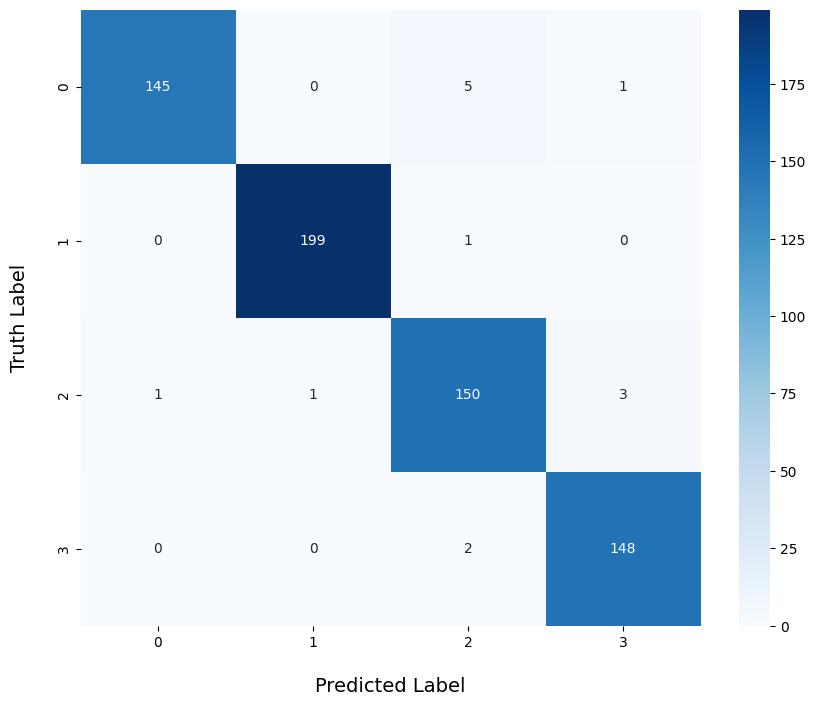

Class: 0
  Precision: 0.9931506849315068
  Recall: 0.9602649006622517
  F1 Score: 0.9764309764309764
Class: 1
  Precision: 0.995
  Recall: 0.995
  F1 Score: 0.995
Class: 2
  Precision: 0.9493670886075949
  Recall: 0.967741935483871
  F1 Score: 0.9584664536741214
Class: 3
  Precision: 0.9736842105263158
  Recall: 0.9866666666666667
  F1 Score: 0.9801324503311258


In [42]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(gen_labels_test_set, best_model_preds)
labels = sorted(set(gen_labels_test_set))

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label', labelpad=20, fontsize=14)
plt.ylabel('Truth Label', labelpad=20, fontsize=14)
plt.show()

precision_per_class = precision_score(gen_labels_test_set, best_model_preds, average=None)
recall_per_class = recall_score(gen_labels_test_set, best_model_preds, average=None)
f1_per_class = f1_score(gen_labels_test_set, best_model_preds, average=None)

for i, label in enumerate(labels):
    print(f'Class: {label}')
    print(f'  Precision: {precision_per_class[i]}')
    print(f'  Recall: {recall_per_class[i]}')
    print(f'  F1 Score: {f1_per_class[i]}')
